In [1]:
import whitebox
import os
import shutil
import fiona 
import geopandas as gpd
import matplotlib.pyplot as plt

In [138]:
##### initialize whitebox

# import whitebox tools class as wbt object
wbt = whitebox.WhiteboxTools()

# toggle on/off geoprocessing tool outputs
# wbt.verbose = False

# set working directory for input/output files to current working directory
wbt.set_working_dir(os.getcwd())

# print whitebox version to verify correctly loading
wbt.version()

# NOTE: original terrain features calculated in ArcGIS Pro, but can be done using Whitebox

"WhiteboxTools v2.3.0 (c) Dr. John Lindsay 2017-2023\n\nWhiteboxTools is an advanced geospatial data analysis platform developed at\nthe University of Guelph's Geomorphometry and Hydrogeomatics Research \nGroup (GHRG). See www.whiteboxgeo.com for more details.\n"

# DEM Pre-Processing

In [139]:
###### copy original dem to current working directory - whitebox doesn't like different directories

# path to original dem
original_dem_path = r'../Data/dem_10m/dem_10m_clipped_26916.tif'

# path to copy original dem (current workind directory plus same basename)
copy_dem_path = os.path.join(r'terrain_features', os.path.basename(original_dem_path))

# check that original dem does exist
if os.path.exists(original_dem_path):

    # check that copy dem does NOT already exist
    if not os.path.exists(copy_dem_path):

        # copy original dem to new location
        shutil.copy(original_dem_path, copy_dem_path)

    else:
        print('Copy DEM already exists...')

else:
    print('Original DEM does not exist in specified path!')

Copy DEM already exists...


## Feature Preserving Smoothing

In [140]:
##### https://www.whiteboxgeo.com/manual/wbt_book/available_tools/geomorphometric_analysis.html#FeaturePreservingSmoothing

# path to copied mosaic and clipped dem in UTM projection - whitebox 2.3.0 does NOT like relative paths for input!!!
input_dem = os.path.abspath(r'terrain_features/dem_10m_clipped_26916.tif')

# path for smoothed output dem - whitebox 2.3.0 does NOT like relative paths for output!!!
output_dem = os.path.abspath(r'terrain_features/dem_fps.tif')


# check that smooth dem does not already exist
if not os.path.exists(output_dem):

    # smooth dem for further processing (default params: filter=11, norm_diff=15, num_iter=3, max_diff=0.5)
    wbt.feature_preserving_smoothing(dem=input_dem, output=output_dem, filter=5, norm_diff=5, num_iter=3)

else:
    print('DEM has already been smoothed and exists...')

DEM has already been smoothed and exists...


## Hydrological Integrity

### Get Streams

In [38]:
# path to geodatabase
gdb_path = r'../Data/nhdplus_hr/KY_NHDPlus_H_National_Release_1_26916.gdb'

# list all layers to find correct feature class name
layers = fiona.listlayers(gdb_path)
for layer in layers:
    print(layer)

KY_NHDPlusConnect
KY_NHDPlusFlow
KY_NHDPlusGageSmooth
KY_WBDHU12
KY_WBDHU10_ProjectBoundary
KY_NHDPlusWall
KY_NHDWaterbody
KY_NHDPlusBoundaryUnit
KY_NHDArea
KY_NHDPoint
KY_NHDPlusSink
FlowlineEndPoints
KY_NHDPlusGage
KY_NonNetworkNHDFlowline
KY_NetworkNHDFlowline
KY_NHDPlusCatchment
KY_NHDLine


In [41]:
# read flowlines into geodataframe; specify feature class name from list above
flowline_features = gpd.read_file(gdb_path, layer='KY_NetworkNHDFlowline')

# display geodataframe head
flowline_features.head()

,permanent_identifier,fdate,resolution,gnis_id,gnis_name,lengthkm,reachcode,flowdir,wbarea_permanent_identifier,ftype,...,petma,qlossma,qgadjma,qgnavma,gageadjma,avgqadjma,gageidma,gageqma,Shape_Length,geometry
0,{97B7AFFD-3DCC-49AD-BF3E-95ACBD9C684C},2014-07-02 00:00:00+00:00,2,00505387,Town Branch,0.414145,05090201001996,1,None,460,...,0.0,0.0,0.0,0.0,0,0.0,0,0.0,412.869429,MULTILINESTRING Z ((826995.130 4274624.726 0.0...
1,32022680,2012-03-15 12:03:28+00:00,2,None,None,0.710000,05100101009366,1,None,460,...,0.0,0.0,0.0,0.0,0,0.0,0,0.0,711.009098,MULTILINESTRING Z ((848076.521 4183208.026 0.0...
2,67615349,2012-03-26 16:26:51+00:00,2,01543309,Mill Creek,1.086000,05070201000502,1,None,460,...,0.0,0.0,0.0,0.0,0,0.0,0,0.0,1087.024533,MULTILINESTRING Z ((888896.956 4226056.654 0.0...
3,54774989,2012-03-01 07:19:17+00:00,2,None,None,1.307000,05090103001008,1,None,460,...,0.0,0.0,0.0,0.0,0,0.0,0,0.0,1298.844997,MULTILINESTRING Z ((837653.886 4267028.500 0.0...
4,26933128,2012-03-01 07:57:16+00:00,2,00490949,Doctors Branch,0.247000,05090104000497,1,None,460,...,0.0,0.0,0.0,0.0,0,0.0,0,0.0,249.123135,MULTILINESTRING Z ((834575.229 4221284.913 0.0...


In [42]:
flowline_features.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 360392 entries, 0 to 360391
Data columns (total 83 columns):
 #   Column                       Non-Null Count   Dtype              
---  ------                       --------------   -----              
 0   permanent_identifier         360392 non-null  object             
 1   fdate                        360392 non-null  datetime64[ns, UTC]
 2   resolution                   360392 non-null  int64              
 3   gnis_id                      109017 non-null  object             
 4   gnis_name                    109017 non-null  object             
 5   lengthkm                     360392 non-null  float64            
 6   reachcode                    360392 non-null  object             
 7   flowdir                      360392 non-null  int64              
 8   wbarea_permanent_identifier  77565 non-null   object             
 9   ftype                        360392 non-null  int64              
 10  fcode                   

In [45]:
flowline_features['streamorde'].value_counts()

streamorde
1     197759
2      78269
3      40937
4      21506
5      11094
6       5369
7       2810
8       1400
9       1134
10       114
Name: count, dtype: int64

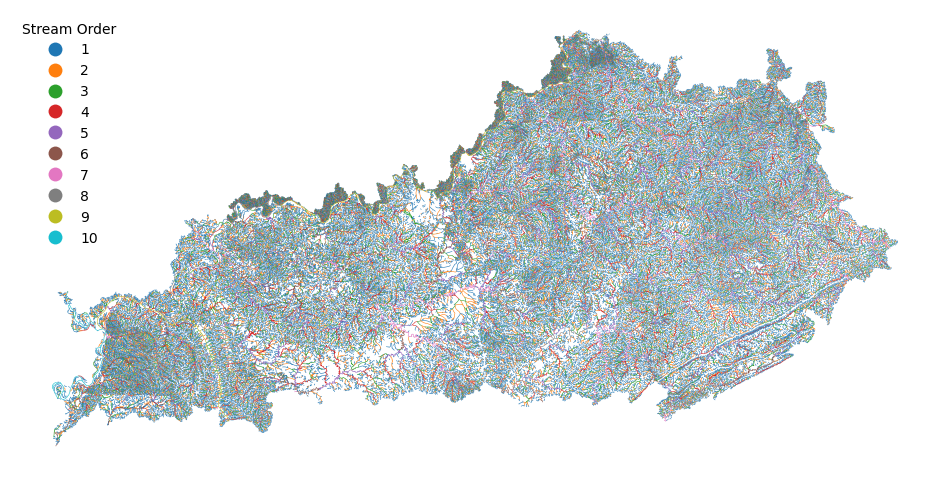

In [133]:
fig, ax = plt.subplots(figsize=(12,7))

flowline_features.plot(column='streamorde', 
                       categorical=True, 
                       linewidth=0.4, 
                       ax=ax, 
                       label='Stream Order', 
                       legend=True, 
                       legend_kwds={'title':'Stream Order', 'frameon':False,
                                    'bbox_to_anchor':(0,1), 'loc':'upper left'})

ax.set_axis_off()

plt.show()

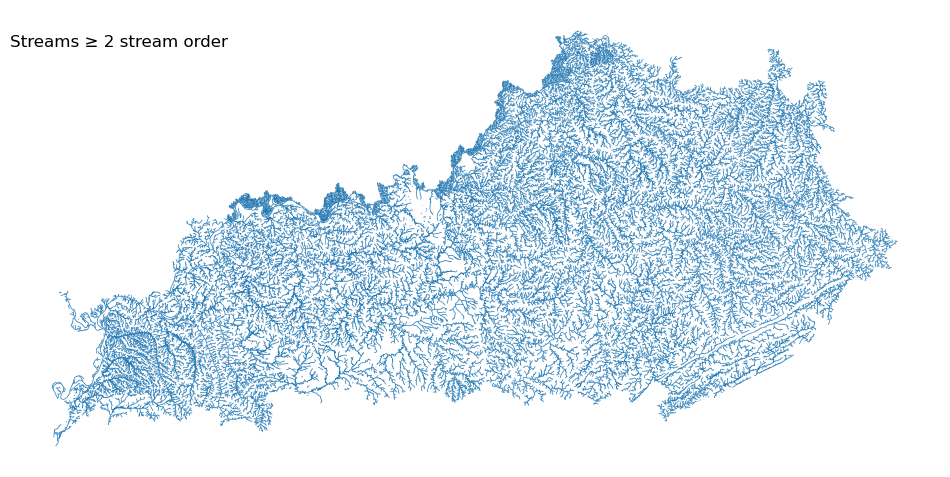

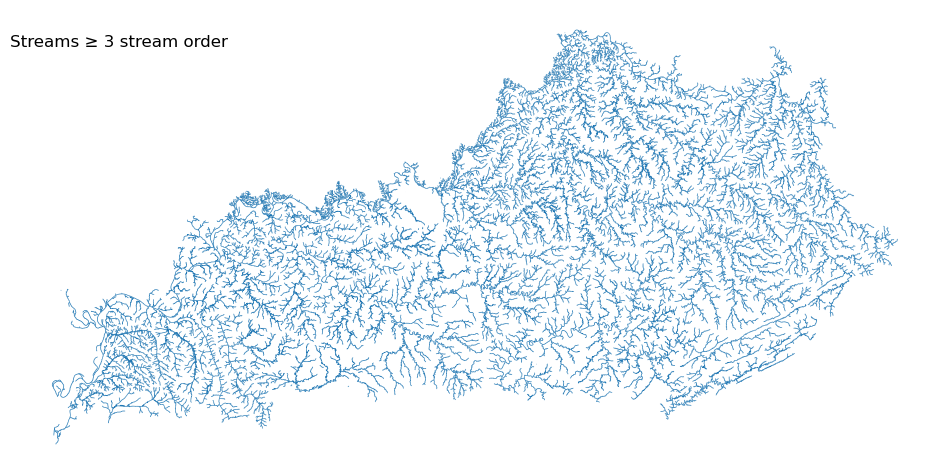

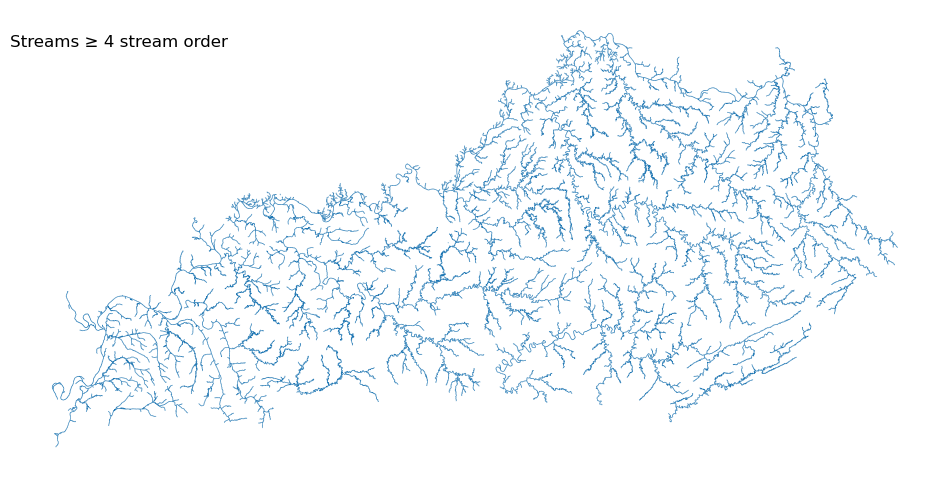

In [134]:
minimum_stream_order = 3

for minimum_stream_order in range(2,5):
    
    fig, ax = plt.subplots(figsize=(12,7))
    
    flowline_features[flowline_features['streamorde'] >= minimum_stream_order].plot(linewidth=0.5, ax=ax)
    
    ax.set_axis_off()
    ax.set_title(f"Streams \u2265 {minimum_stream_order} stream order", y=0.9, loc='left')
    
    plt.show()

In [137]:
minimum_stream_order_threshold = 3

flowline_shapefile_output = f"terrain_features/nhdplus_hr_order{minimum_stream_order_threshold}_26916.shp"

if not os.path.exists(flowline_shapefile_output):
    mask = flowline_features['streamorde'] >= 3
    flowline_features.loc[mask, ['gnis_id', 'streamorde', 'geometry']].to_file(flowline_shapefile_output)

else:
    print('Shapefile already exists...')

### Burn Streams in DEM

In [141]:
# burn streams in smoothed dem...

input_dem = os.path.abspath(r'terrain_features/dem_fps.tif')
input_flowlines = os.path.abspath(r'terrain_features/nhdplus_hr_order3_26916.shp')

output_dem = os.path.abspath(r'terrain_features/dem_fps_burned.tif')


# out_flowline = os.path.abspath(r'terrain_features/stream_prunednetwork.tif')
# out_flowdirection = os.path.abspath(r'terrain_features/stream_flowdirection.tif')
# out_flowaccumulation = os.path.abspath(r'terrain_features/stream_flowaccumulation.tif')

# wbt.topological_breach_burn(
#     streams=flowline_path, 
#     dem=dem_path, 
#     out_streams=out_flowline, 
#     out_dem=out_dem, 
#     out_dir=out_flowdirection, 
#     out_accum=out_flowaccumulation, 
#     snap=1.0, 
#     callback=default_callback
# )


# check that smooth dem does not already exist
if not os.path.exists(output_dem):

    # burn streams in smoothed DEM
    wbt.fill_burn(dem=input_dem, streams=input_flowlines, output=output_dem)

else:
    print('DEM has already been burned and exists...')

./whitebox_tools --run="FillBurn" --wd="/Users/Matthew/Documents/GitHub/watersheds/TerrainFeatures" --dem='/Users/Matthew/Documents/GitHub/watersheds/TerrainFeatures/terrain_features/dem_fps.tif' --streams='/Users/Matthew/Documents/GitHub/watersheds/TerrainFeatures/terrain_features/nhdplus_hr_order3_26916.shp' --output='/Users/Matthew/Documents/GitHub/watersheds/TerrainFeatures/terrain_features/dem_fps_burned.tif' -v --compress_rasters=False

****************************
* Welcome to FillBurn      *
* Powered by WhiteboxTools *
* www.whiteboxgeo.com      *
****************************
Reading streams data...
Reading DEM data...
Rasterizing Streams: 0%
Rasterizing Streams: 1%
Rasterizing Streams: 2%
Rasterizing Streams: 3%
Rasterizing Streams: 4%
Rasterizing Streams: 5%
Rasterizing Streams: 6%
Rasterizing Streams: 7%
Rasterizing Streams: 8%
Rasterizing Streams: 9%
Rasterizing Streams: 10%
Rasterizing Streams: 11%
Rasterizing Streams: 12%
Rasterizing Streams: 13%
Rasterizing Streams: 14%

In [ ]:
# fill single cell depressions (final pre-processing step)

input_dem = os.path.abspath(r'terrain_features/dem_fps_burned.tif')
output_dem = os.path.abspath(r'terrain_features/dem_fps_burned_singlecellfill.tif')


# check that smooth dem has not already been processed
if not os.path.exists(output_dem):

    # fill single-cell pits/depressions in smoothed & burned dem
    wbt.fill_single_cell_pits(dem=input_dem, output=output_dem)


else:
    print('DEM has already been filled and exists...')

# Terrain Features

In [ ]:
# path to pre-processed DEM (smoothed, stream burn, single-cell fill)
dem_input_path = os.path.abspath(r'terrain_features/dem_fps_burned_singlecellfill.tif')

## Slope

In [ ]:
# calculate slope (degrees)

output_path = os.path.abspath(r'terrain_features/slope_deg.tif')

wbt.slope(
    dem=dem_input_path, 
    output=output_path, 
    zfactor=None, 
    units='degrees', 
)

In [ ]:
# add small slope so nothing is completely flat?

## Aspect

In [ ]:
# calculate aspect (0-360 degrees); shouldn't be any flat/undefined areas because added small slope

output_path = os.path.abspath(r'terrain_features/aspect.tif')

wbt.aspect(
    dem, 
    output, 
    zfactor=None, 
    callback=default_callback
)

## Profile Curvature

## Tangential Curvature

## Roughness Index

In [1]:
# multiple windows

## Standard Devation of Elevation

In [2]:
# multiple windows

## Topographic Postion Index

In [ ]:
# multiple windows

## Topographic Wetness Index

## Stream Power Index

## Drainage Density (Watershed measurement)